In [1]:
from google.colab import files
files.upload()  # Upload kaggle (1).json

# Fix for the correct filename with space
!mkdir -p ~/.kaggle/
!cp "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle (2).json to kaggle (2) (7).json


In [2]:
!kaggle datasets download -d adityajn105/flickr8k
!unzip -q flickr8k.zip

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
!unzip -l flickr8k.zip


Streaming output truncated to the last 5000 lines.
   193348  2020-04-27 07:28   Images/2845246160_d0d1bbd6f0.jpg
    70736  2020-04-27 07:28   Images/2845691057_d4ab89d889.jpg
   111711  2020-04-27 07:28   Images/2845845721_d0bc113ff7.jpg
   160979  2020-04-27 07:28   Images/2846037553_1a1de50709.jpg
    76823  2020-04-27 07:28   Images/2846785268_904c5fcf9f.jpg
   219425  2020-04-27 07:28   Images/2846843520_b0e6211478.jpg
   137247  2020-04-27 07:28   Images/2847514745_9a35493023.jpg
    71116  2020-04-27 07:28   Images/2847615962_c330bded6e.jpg
   134929  2020-04-27 07:28   Images/2847859796_4d9cb0d31f.jpg
   146325  2020-04-27 07:28   Images/2848266893_9693c66275.jpg
   226184  2020-04-27 07:28   Images/2848571082_26454cb981.jpg
   171034  2020-04-27 07:28   Images/2848895544_6d06210e9d.jpg
   179109  2020-04-27 07:28   Images/2848977044_446a31d86e.jpg
   127300  2020-04-27 07:28   Images/2849194983_2968c72832.jpg
   244872  2020-04-27 07:28   Images/2850719435_221f15e951.jpg
   2

In [4]:
!unzip flickr8k.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./Images/2844846111_8c1cbfc75d.jpg  
  inflating: ./Images/2844963839_ff09cdb81f.jpg  
  inflating: ./Images/2845246160_d0d1bbd6f0.jpg  
  inflating: ./Images/2845691057_d4ab89d889.jpg  
  inflating: ./Images/2845845721_d0bc113ff7.jpg  
  inflating: ./Images/2846037553_1a1de50709.jpg  
  inflating: ./Images/2846785268_904c5fcf9f.jpg  
  inflating: ./Images/2846843520_b0e6211478.jpg  
  inflating: ./Images/2847514745_9a35493023.jpg  
  inflating: ./Images/2847615962_c330bded6e.jpg  
  inflating: ./Images/2847859796_4d9cb0d31f.jpg  
  inflating: ./Images/2848266893_9693c66275.jpg  
  inflating: ./Images/2848571082_26454cb981.jpg  
  inflating: ./Images/2848895544_6d06210e9d.jpg  
  inflating: ./Images/2848977044_446a31d86e.jpg  
  inflating: ./Images/2849194983_2968c72832.jpg  
  inflating: ./Images/2850719435_221f15e951.jpg  
  inflating: ./Images/2851198725_37b6027625.jpg  
  inflating: ./Images/2851304910_b5721199bc.jpg  

In [5]:
import pandas as pd

def load_descriptions(file):
    df = pd.read_csv(file, sep=',')
    df['caption'] = df['caption'].apply(lambda x: f"startseq {x.lower()} endseq")
    descriptions = {}
    for row in df.itertuples(index=False):
        key = row.image.replace('.jpg', '')
        descriptions.setdefault(key, []).append(row.caption)
    return descriptions

descriptions = load_descriptions("captions.txt")


In [6]:
!kaggle datasets download -d mrtejas/flickr8k-features-inceptionv3
!unzip -q flickr8k-features-inceptionv3.zip


Dataset URL: https://www.kaggle.com/datasets/mrtejas/flickr8k-features-inceptionv3
License(s): unknown
flickr8k-features-inceptionv3.zip: Skipping, found more recently modified local copy (use --force to force download)
replace features_InceptionV3.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [7]:
import pickle

with open("/content/features_InceptionV3.pkl", "rb") as f:
    image_features = pickle.load(f)

print("✅ Loaded features:", len(image_features))


✅ Loaded features: 8091


In [8]:
import pandas as pd

def load_descriptions(file):
    df = pd.read_csv(file, sep=',')
    df['caption'] = df['caption'].apply(lambda x: f'startseq {x.lower()} endseq')
    descriptions = {}
    for row in df.itertuples(index=False):
        key = row[0].split('.')[0]  # remove .jpg
        descriptions.setdefault(key, []).append(row[1])
    return descriptions

descriptions = load_descriptions("captions.txt")
print("✅ Captions loaded:", len(descriptions))


✅ Captions loaded: 8091


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Flatten all captions
all_captions = [caption for caps in descriptions.values() for caption in caps]

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print("🔤 Vocab size:", vocab_size)

# Max caption length
max_length = max(len(caption.split()) for caption in all_captions)
print("📏 Max caption length:", max_length)


🔤 Vocab size: 8496
📏 Max caption length: 40


In [10]:
filtered_features = {k: image_features[k] for k in descriptions if k in image_features}
print("✅ Filtered features:", len(filtered_features))


✅ Filtered features: 8091


In [11]:
from tensorflow.keras.utils import to_categorical

def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = [], [], []

    for key, desc_list in descriptions.items():
        if key not in photos:
            continue
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)

    return np.array(X1), np.array(X2), np.array(y)


In [12]:
# For now use only first 3000 images to avoid memory issues
subset = dict(list(descriptions.items())[:500])
filtered_subset_features = {k: image_features[k] for k in subset if k in image_features}

X1, X2, y = create_sequences(tokenizer, max_length, subset, filtered_subset_features, vocab_size)

print("✅ Final shapes:")
print("Image features (X1):", X1.shape)
print("Input sequences (X2):", X2.shape)
print("Next word targets (y):", y.shape)


✅ Final shapes:
Image features (X1): (30242, 2048)
Input sequences (X2): (30242, 40)
Next word targets (y): (30242, 8496)


In [13]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# Feature extractor model (image input)
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence processor model (text input)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder (combine image + text)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Final model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 256)   │  2,174,976 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 40)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8496)      │  2,183,472 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,474,096 (20.88 MB)

 Trainable params: 5,474,096 (20.88 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit([X1, X2], y, epochs=10, batch_size=64, verbose=1)


Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 181s 373ms/step - loss: 5.5958
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 204s 378ms/step - loss: 3.9620
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 206s 388ms/step - loss: 3.4683
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 195s 373ms/step - loss: 3.1352
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 199s 368ms/step - loss: 2.8268
Epoch 6/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 210s 385ms/step - loss: 2.5848
Epoch 7/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 178s 377ms/step - loss: 2.2998
Epoch 8/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 204s 382ms/step - loss: 2.0936
Epoch 9/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 205s 387ms/step - loss: 1.8930
Epoch 10/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 175s 370ms/step - loss: 1.7216


In [15]:
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq', '').replace('endseq', '').strip()


In [22]:
sample_key = list(filtered_subset_features.keys())[3]
sample_feature = filtered_subset_features[sample_key]

caption = generate_caption(model, tokenizer, sample_feature, max_length)
print("🖼️ Image ID:", sample_key)
print("📝 Generated Caption:", caption)


🖼️ Image ID: 1003163366_44323f5815
📝 Generated Caption: a man lies on a bench while sitting on a wooden bench


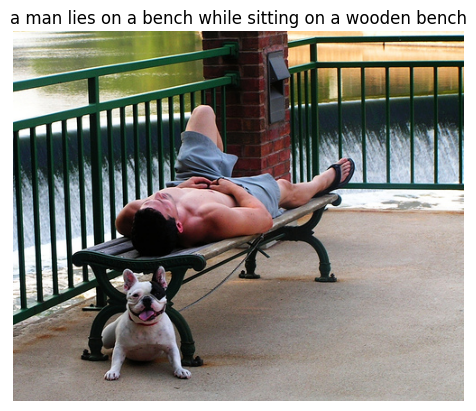

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = f"Images/{sample_key}.jpg"
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()
